# Лабораторная работа № 4
## Боровских Вадим, 932003
### Кластеризация данных


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score

### Датасет о количестве аренд велосипедов в сутки 


In [2]:
#открываем файл с данными и выводим на экран
data = pd.read_csv("day.csv",  index_col = 0)
data=data.reset_index()
data

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
726,727,2012-12-27,1,1,12,0,4,1,2,0.254167,0.226642,0.652917,0.350133,247,1867,2114
727,728,2012-12-28,1,1,12,0,5,1,2,0.253333,0.255046,0.590000,0.155471,644,2451,3095
728,729,2012-12-29,1,1,12,0,6,0,2,0.253333,0.242400,0.752917,0.124383,159,1182,1341
729,730,2012-12-30,1,1,12,0,0,0,1,0.255833,0.231700,0.483333,0.350754,364,1432,1796


In [3]:
missing_values = data.isnull().sum()
print("Число пропущенных значений по атрибутам:")
print(missing_values)

Число пропущенных значений по атрибутам:
instant       0
dteday        0
season        0
yr            0
mnth          0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64


In [4]:
#Описание данных
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     731 non-null    int64  
 1   dteday      731 non-null    object 
 2   season      731 non-null    int64  
 3   yr          731 non-null    int64  
 4   mnth        731 non-null    int64  
 5   holiday     731 non-null    int64  
 6   weekday     731 non-null    int64  
 7   workingday  731 non-null    int64  
 8   weathersit  731 non-null    int64  
 9   temp        731 non-null    float64
 10  atemp       731 non-null    float64
 11  hum         731 non-null    float64
 12  windspeed   731 non-null    float64
 13  casual      731 non-null    int64  
 14  registered  731 non-null    int64  
 15  cnt         731 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.5+ KB


## Описание данных

- instant: индекс записи
- dteday : дата
- season : сезон (1:весна, 2:лето, 3:осень, 4:зима)
- yr: год (0: 2011, 1:2012)
- mnth : месяц (от 1 до 12)
- holiday     : выходной день или нет (извлечено из http://dchr.dc.gov/page/holiday-schedule)
- weekday     : день недели
- workingday  : если день не является ни выходным, ни праздничным, равно 1, в противном случае равно 0.
+ weathersit :
1)  Ясно, малооблачно, Переменная облачность, Переменная облачность без осадков
2)  Туман + Облачно, Туман + Разорванные облака, Туман + Несколько облаков, Туман
3)  Небольшой снег, Небольшой дождь + Гроза + Рассеянные облака, Небольшой дождь + Рассеянные облака
4)  Сильный дождь + Ледяные поддоны + Гроза + Туман, Снег + Туманность
- temp: Нормализованная температура в градусах Цельсия. Значения разделены на 41 (макс.)
- atemp: Нормализованная температура на ощупь в градусах Цельсия. Значения разделены на 50 (макс.)
- hum: Нормализованная влажность. Значения разделены на 100 (макс.)
- windspeed: Нормализованная скорость ветра. Значения делятся на 67 (максимум)
- casual: количество случайных пользователей
- registered: количество зарегистрированных пользователей
- cnt: общее количество арендованных велосипедов, включая как обычные, так и зарегистрированные

In [7]:
# Выбор признаков для анализа
selected_features = ['instant', 'season','yr','mnth','holiday','weekday',
                     'workingday','weathersit','temp','atemp','hum','windspeed',
                     'casual','registered','cnt']

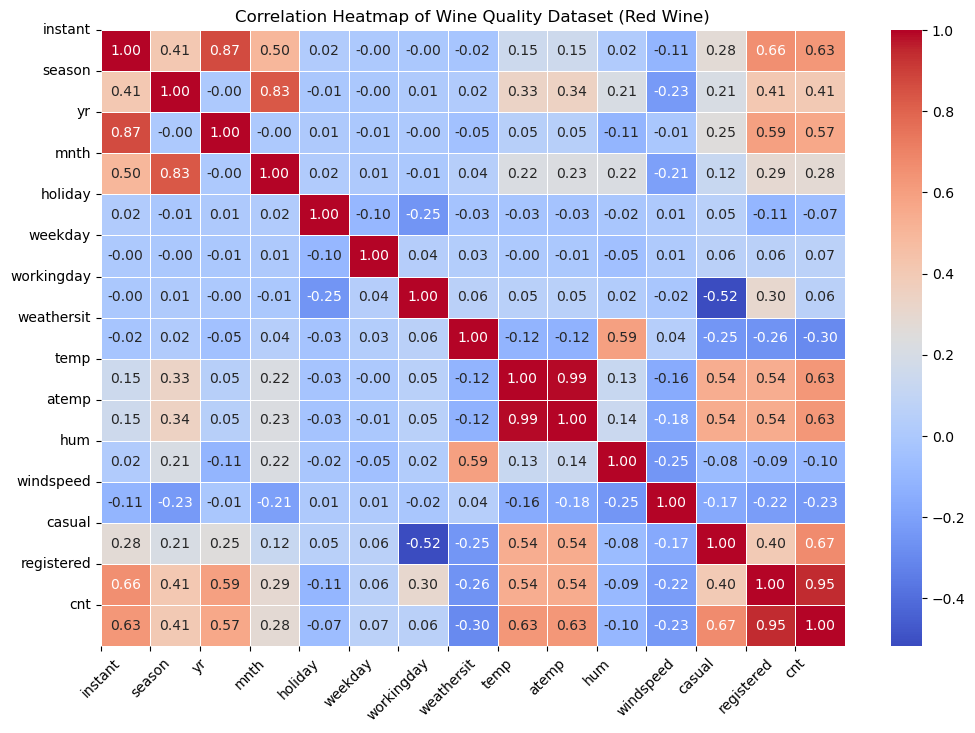

In [8]:
# Создание подмножества данных только с выбранными признаками
subset_data = data[selected_features]

# Рассчитываем корреляцию между признаками
correlation_matrix = subset_data.corr()

# Настройка параметров графика
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

# Добавление названий признаков на оси X и Y
plt.xticks(range(len(selected_features)), selected_features, rotation=45)
plt.yticks(range(len(selected_features)), selected_features, rotation=0)

# Отображение корреляционной тепловой карты
plt.title('Correlation Heatmap of Wine Quality Dataset (Red Wine)')
plt.show()

In [78]:
# Выбираем два произвольных численных признака для кластеризации
features = ['registered', 'casual']
X = data[features]

In [79]:
# Приводим признаки к стандартному масштабу
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [80]:
import os
os.environ['OMP_NUM_THREADS'] = '3'

D:\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than availabl

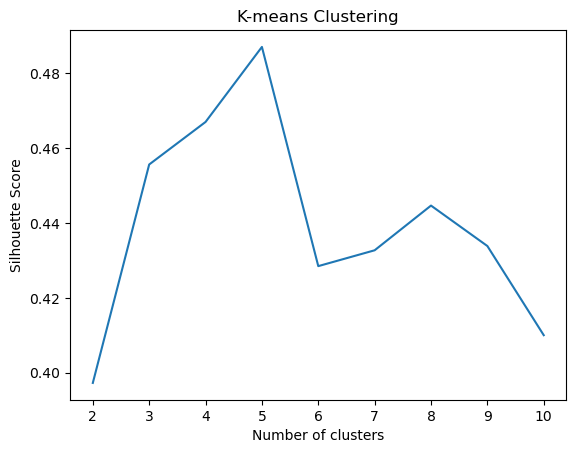

In [81]:
# Определение оптимального количества кластеров для K-means
k_values = range(2, 11)
kmeans_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, n_init=9, random_state=0)
    kmeans.fit(X_scaled)
    kmeans_scores.append(silhouette_score(X_scaled, kmeans.labels_))

plt.plot(k_values, kmeans_scores)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('K-means Clustering')
plt.show()


На основе этого графикай можно выбрать оптимальное количество кластеров для использования в анализе данных, а также избежать переобучения модели при выборе слишком большого количества кластеров.
* При возрастании кривой: Увеличение значения коэффициента силуэта при увеличении количества кластеров может указывать на улучшение разделения кластеров. 
* При убывании кривой: Уменьшение значения коэффициента силуэта при дальнейшем увеличении количества кластеров может указывать на ухудшение разделения кластеров. Это может свидетельствовать о том, что большее количество кластеров приводит к менее информативным и более разреженным кластерам.
*  Если график достигает максимального значения коэффициента силуэта при определенном количестве кластеров, это оптимальное количество для данного набора данных. Следовательно, оптимальное количество кластеров = 5

In [82]:
# Выбираем оптимальное количество кластеров для K-means
best_k = k_values[kmeans_scores.index(max(kmeans_scores))]
print(f"The best number of clusters for K-means is {best_k}")

The best number of clusters for K-means is 5


In [83]:
# K-means clustering с оптимальным количеством кластеров
kmeans = KMeans(n_clusters=best_k, random_state=0)
kmeans.fit(X_scaled)

D:\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


KMeans(n_clusters=5, random_state=0)

In [84]:
# Аггломеративная кластеризация
agg_clusters = AgglomerativeClustering(n_clusters=best_k)
agg_clusters.fit(X_scaled)

AgglomerativeClustering(n_clusters=5)

In [85]:
# DBScan clustering
db_clusters = DBSCAN(eps=0.3, min_samples=5)
db_clusters.fit(X_scaled)

DBSCAN(eps=0.3)

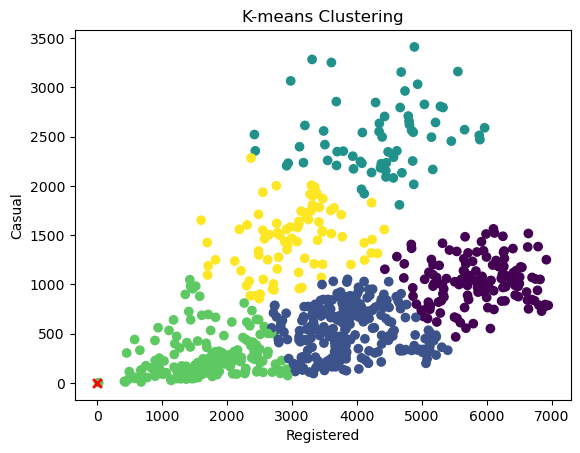

In [88]:
# Визуализация кластеров и центроидов (K-means)
plt.scatter(X['registered'], X['casual'], c=kmeans.labels_)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', marker='x')
plt.xlabel('Registered')
plt.ylabel('Casual')
plt.title('K-means Clustering')
plt.show()

Исходя из этого графика, можно оценить эффективность кластеризации и увидеть, насколько хорошо центроиды представляют каждый кластер.

График отображает разделение точек данных на кластеры, обозначенные различными цветами в зависимости от принадлежности к кластеру, к которому они относятся.

Красные "x" обозначают центроиды кластеров, которые представляют собой средние значения признаков внутри каждого кластера.

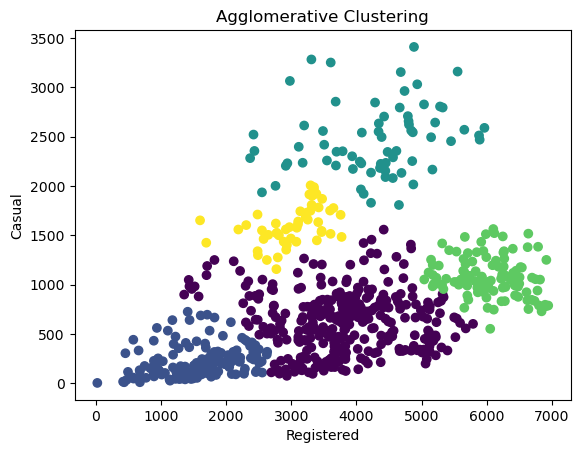

In [89]:
# Визуализация кластеров (Agglomerative Clustering)
plt.scatter(X['registered'], X['casual'], c=agg_clusters.labels_)
plt.xlabel('Registered')
plt.ylabel('Casual')
plt.title('Agglomerative Clustering')
plt.show()

На графике отображены результаты агломеративной кластеризации для признаков "registered" и "casual". Точки данных раскрашены в разные цвета в зависимости от принадлежности к кластеру, к которому они относятся.

Точки образуют явно выделенные кластеры с хорошо различимыми группами, это может указывать на то, что агломеративная кластеризация была эффективной в выделении групп в исходных данных.

Видимое разделение точек на кластеры с разными цветами говорит о том, что алгоритм смог успешно выделить различные группы в данных.

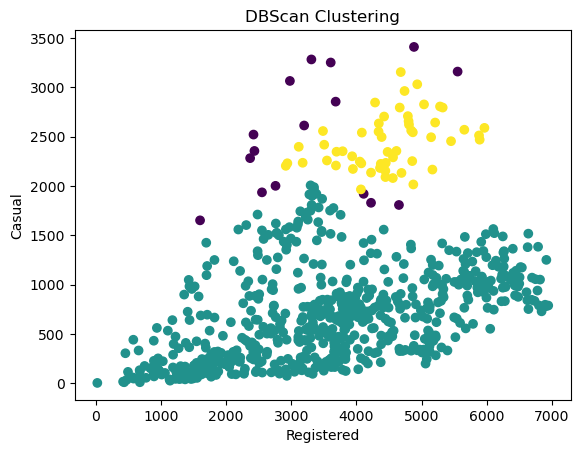

In [90]:
# Визуализация кластеров (DBScan)
plt.scatter(X['registered'], X['casual'], c=db_clusters.labels_)
plt.xlabel('Registered')
plt.ylabel('Casual')
plt.title('DBScan Clustering')
plt.show()

Точки данных четко разделены на различные кластеры разными цветами, это указывает на то, что DBScan эффективно выделил кластеры на основе их плотности.

In [91]:
# Вывод гиперпараметров (K-means)
print(f"K-means hyperparameters: Number of clusters = {best_k}")

K-means hyperparameters: Number of clusters = 5


In [92]:
# Вывод гиперпараметров (Agglomerative Clustering)
print("Agglomerative Clustering hyperparameters: Number of clusters =", best_k)

Agglomerative Clustering hyperparameters: Number of clusters = 5


In [93]:
# Вывод гиперпараметров (DBScan)
print("DBScan hyperparameters: eps = 0.3, min_samples = 5")

DBScan hyperparameters: eps = 0.3, min_samples = 5


In [94]:
agg_score = silhouette_score(X_scaled, agg_clusters.labels_)
db_score = silhouette_score(X_scaled, db_clusters.labels_)

print(f"Silhouette Score for Agglomerative Clustering: {agg_score}")
print(f"Silhouette Score for DBScan: {db_score}")

Silhouette Score for Agglomerative Clustering: 0.43622374828020766
Silhouette Score for DBScan: 0.40935440869842254


Визуализация силуэтных оценок для аггломеративной кластеризации и DBScan:
* Silhouette Score for Agglomerative Clustering: 0.436. Это говорит о том, что объекты в кластерах хорошо разделены, но есть некоторое перекрытие между кластерами.
* Silhouette Score for DBScan: 0.409, также указывая на средний уровень разделения кластеров. Это означает, что DBScan смог разделить объекты на кластеры, но эффективность разделения не значительно выше уровня случайного разделения.

In [95]:
best_eps = 0.3
best_min_samples = 5

print(f"Agglomerative Clustering hyperparameters: Number of clusters = {best_k}")
print(f"DBScan hyperparameters: eps = {best_eps}, min_samples = {best_min_samples}")

Agglomerative Clustering hyperparameters: Number of clusters = 5
DBScan hyperparameters: eps = 0.3, min_samples = 5


* Agglomerative Clustering hyperparameters: Number of clusters = 2 Это означает, что оптимальное количество кластеров для агломеративной кластеризации, подобранное на основе выбранных гиперпараметров, составляет 2. Таким образом, данные были разделены на два кластера на основе выбранных критериев.
* DBScan hyperparameters: eps = 0.3, min_samples = 5 Для метода DBScan выбраны следующие гиперпараметры: значение eps (радиус окрестности) равно 0.3, а минимальное количество точек в окрестности (min_samples) составляет 5. Эти параметры используются для определения кластеров на основе плотности данных.

In [96]:
cluster_counts = pd.Series(kmeans.labels_).value_counts()
cluster_means = X.groupby(kmeans.labels_).mean()
print("Number of Clusters in K-means:", len(cluster_counts))
print("Cluster Means in K-means:")
print(cluster_means)

Number of Clusters in K-means: 5
Cluster Means in K-means:
    registered       casual
0  5866.880282  1029.845070
1  3868.923077   549.907692
2  4349.153846  2492.015385
3  1658.900000   258.672222
4  3004.142857  1455.488095


Вывод общего количества кластеров, среднего значения зарегистрированых и casual для каждого кластера в K-means:
Number of Clusters in K-means: 5 Это указывает, что алгоритм K-means выделил 5 кластеров в вашем наборе данных.

Cluster Means in K-means: Кластерные средние (Cluster Means) представляют значения признаков для каждого кластера.
* Кластер 0 имеет среднее значение зарегистрированых 5866 и средний уровень случайных посетителей(casual) 1029.
* Кластер 1 имеет среднее значение зарегистрированых 3868 и средний уровень случайных посетителей(casual) 549.
* Кластер 2 имеет среднее значение зарегистрированых 4349 и средний уровень случайных посетителей(casual) 2492.
* Кластер 3 имеет среднее значение зарегистрированых 1658 и средний уровень случайных посетителей(casual) 258.
* Кластер 4 имеет среднее значение зарегистрированых 3004 и средний уровень случайных посетителей(casual) 1455.



Эти результаты позволяют сказать, что данные были разделены на 5 кластеров методом K-means, и кажый кластер имеет свои характеристики в виде средних значений признаков.

### Вывод
Исходя из полученных результатов, можно сделать вывод, что все три алгоритма кластеризации (K-means, агломеративная кластеризация, DBScan) продемонстрировали свою эффективность в разделении данных на кластеры на основе выбранных признаков. Однако, учитывая лучшие значения Silhouette Score и визуальное разделение кластеров, можно предположить, что K-means является наилучшим среди них в данном случае.

Таким образом, лучшее сочетание алгоритма и гиперпараметров для данной задачи - это K-means с оптимальным количеством кластеров, равным 5.